In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import scipy as sp
import seaborn as sn
from scipy.stats import gaussian_kde
import matplotlib.pylab as pl
%matplotlib inline

import os 
import hedfpy

from hedfpy.EDFOperator import EDFOperator
from hedfpy.HDFEyeOperator import HDFEyeOperator
from hedfpy.EyeSignalOperator import EyeSignalOperator, detect_saccade_from_data

sn.set(style="ticks")
import warnings
warnings.filterwarnings("ignore")

from PIL import Image

In [3]:
os.chdir('../../experiments/GD/')

edf_file = 'data/tk_1_2017-10-06_16.11.37.edf'

low_pass_pupil_f, high_pass_pupil_f = 6.0, 0.01
alias = 'GD_1'

# initialize the hdfeyeoperator
ho = HDFEyeOperator(os.path.splitext(edf_file)[0] + '.h5')
# insert the edf file contents only when the h5 is not present.
if not os.path.isfile(os.path.splitext(edf_file)[0] + '.h5'):
    ho.add_edf_file(edf_file)
    ho.edf_message_data_to_hdf(alias = alias)
    ho.edf_gaze_data_to_hdf(alias = alias, pupil_hp = high_pass_pupil_f, pupil_lp = low_pass_pupil_f)


In [4]:
gaze_data = [[ho.signal_from_trial_phases(trial_nr=tn, trial_phases=[1,-1], alias=alias, signal='gaze_x_int', requested_eye='L', time_extensions=[0, 0]),
             1024-ho.signal_from_trial_phases(trial_nr=tn, trial_phases=[1,-1], alias=alias, signal='gaze_y_int', requested_eye='L', time_extensions=[0, 0])] for tn in range(13)]

In [5]:
images = [np.asarray(Image.open('imgs/%i.jpg'%i, 'r')) for i in range(1,14)]
for i in range(13):
    if len(images[i].shape) == 2:
        intermediate_image = np.zeros((960,1280,1))
        images[i] = images[i][:,:,np.newaxis]
    else:
        intermediate_image = np.zeros((960,1280,images[i].shape[-1]))
    intermediate_image[96:-96,128:-128] = images[i]
    images[i] = intermediate_image

parameters = ho.read_session_data(alias, 'parameters')
# recode the ordering of the stimuli
images = [images[i] for i in np.array(parameters['stimulus'], dtype=int)]

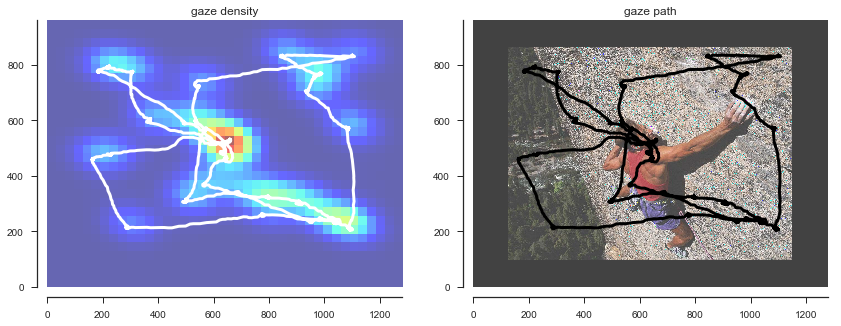

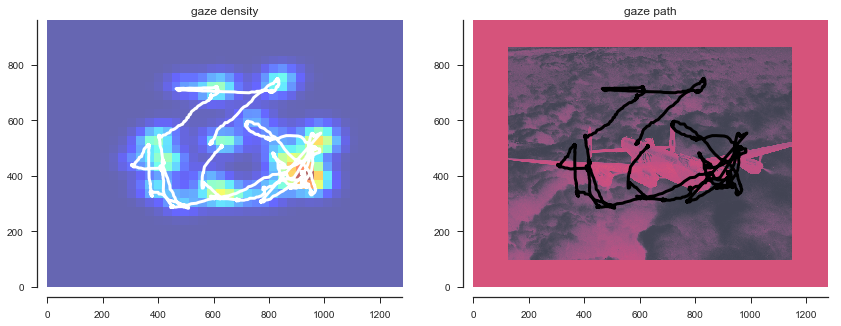

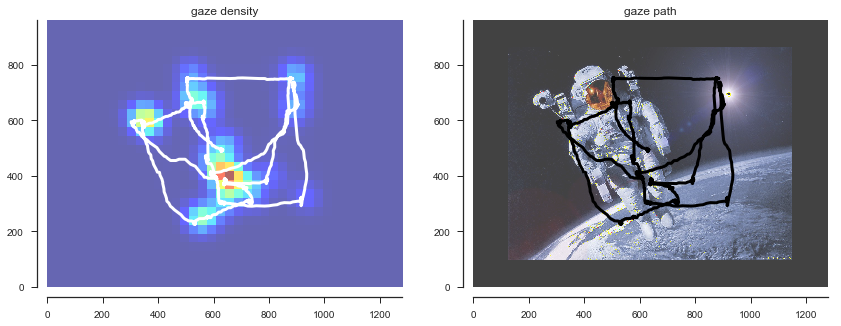

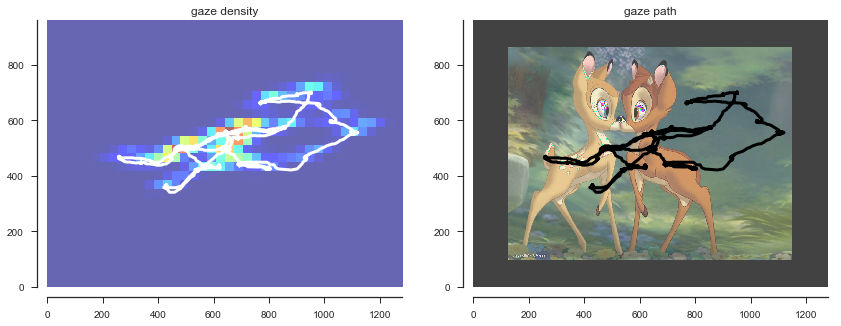

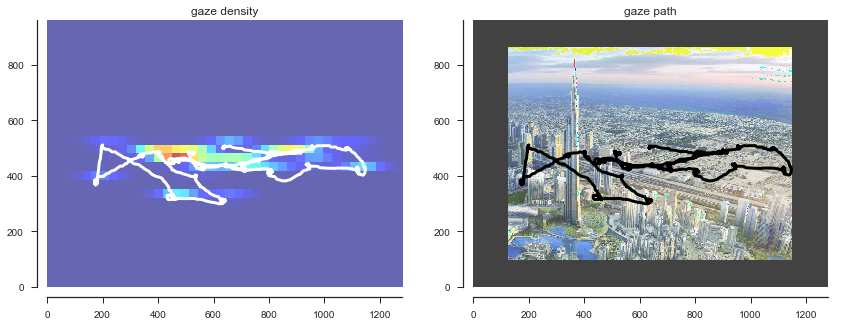

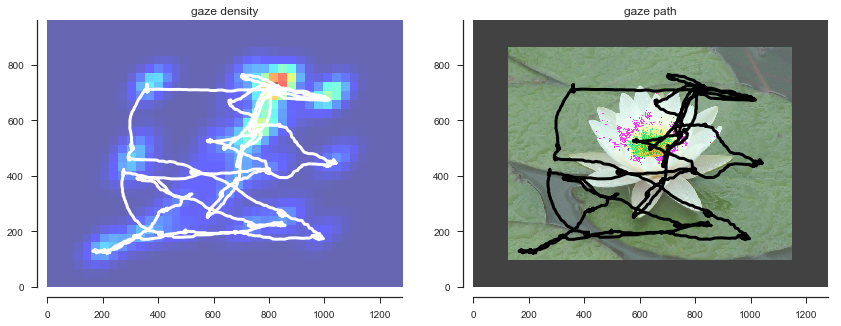

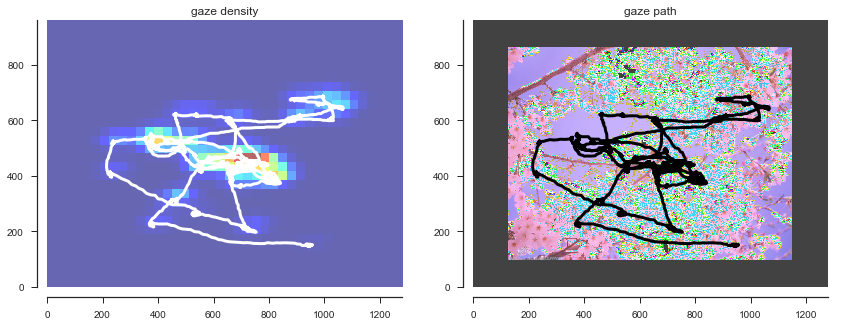

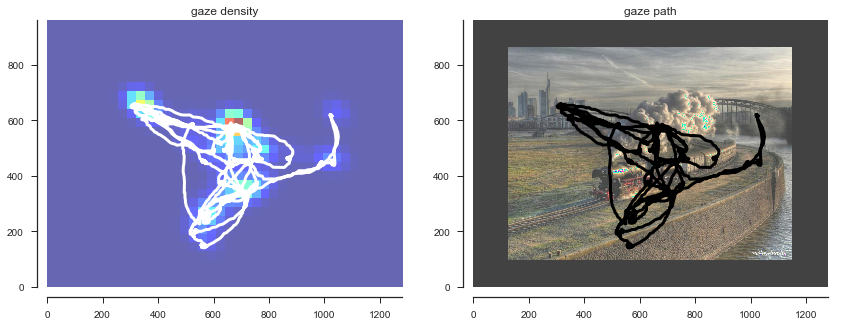

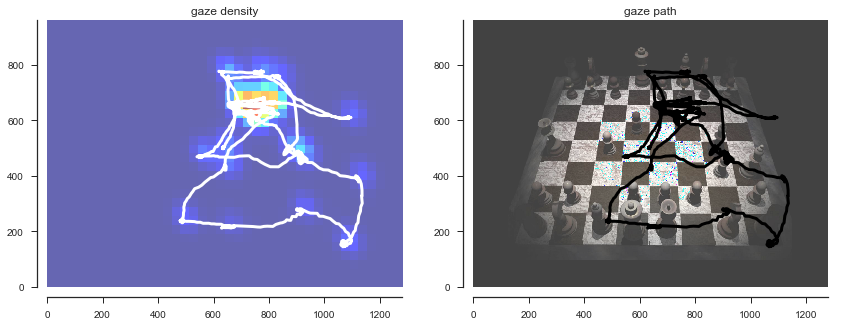

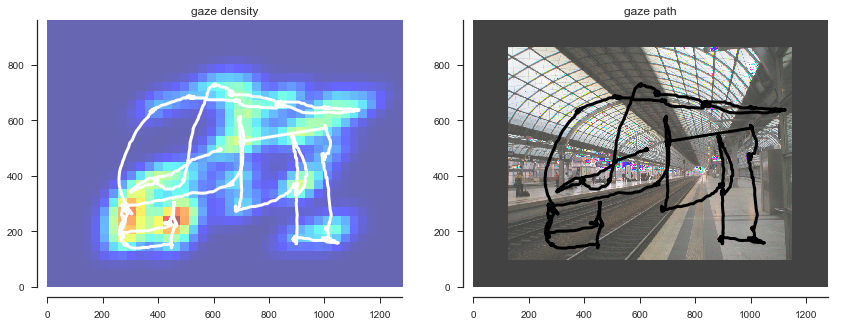

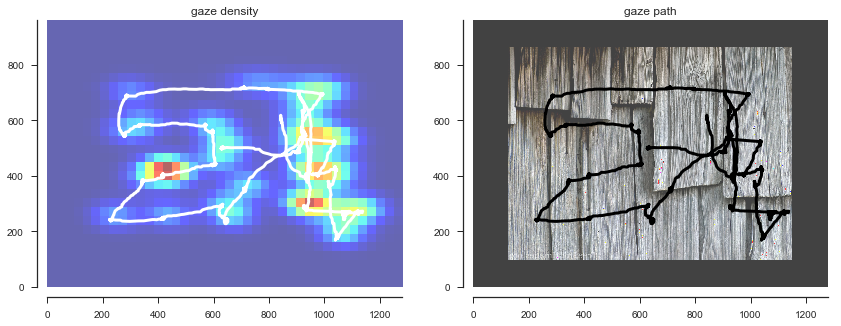

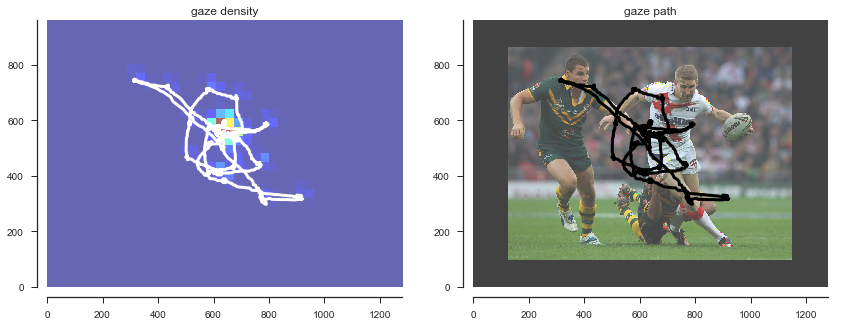

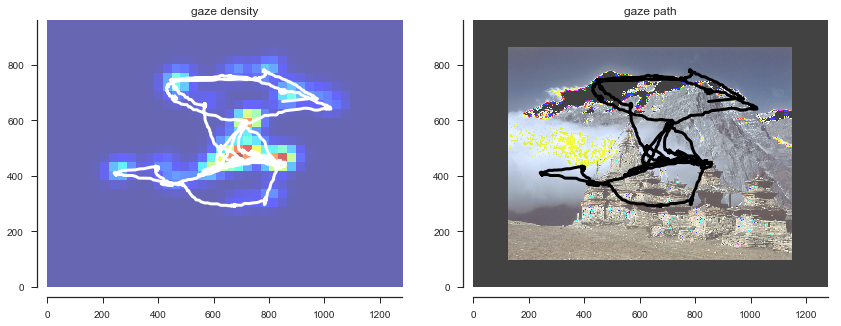

In [6]:
x_pixels, y_pixels = np.meshgrid(np.arange(0,1280,32),np.arange(0,1024,32))
pixel_coordinates = np.array([x_pixels, y_pixels]).reshape((2,-1))

def kde(x,y,image):
    gaze = np.array([x.squeeze(),y.squeeze()])
    gaze_kde = gaussian_kde(gaze)
    
    density = gaze_kde.evaluate(pixel_coordinates)

    # plot these things
    f = pl.figure(figsize = (14,5))
    s = f.add_subplot(121)
    pl.plot(x,y)
    s.set_xlim([0,1280])
    s.set_ylim([0,960])
    sn.despine(ax=s, offset=10)
    pl.imshow(density.reshape(x_pixels.shape)[::-1,:], alpha=0.6, extent=[0,1280,0,1024], cmap='jet')
    pl.plot(x, y, 'w', lw=3)
    s.set_title('gaze density')

    s = f.add_subplot(122)
    pl.imshow(254-image.squeeze()[::-1,::-1], alpha=0.75, clim=[0,512])
    pl.plot(x, y,'k', lw=3)
    s.set_xlim([0,1280])
    s.set_ylim([0,960])
    sn.despine(ax=s, offset=10)
    s.set_title('gaze path')


for i in range(13):
    kde(gaze_data[i][0], gaze_data[i][1], images[i])    


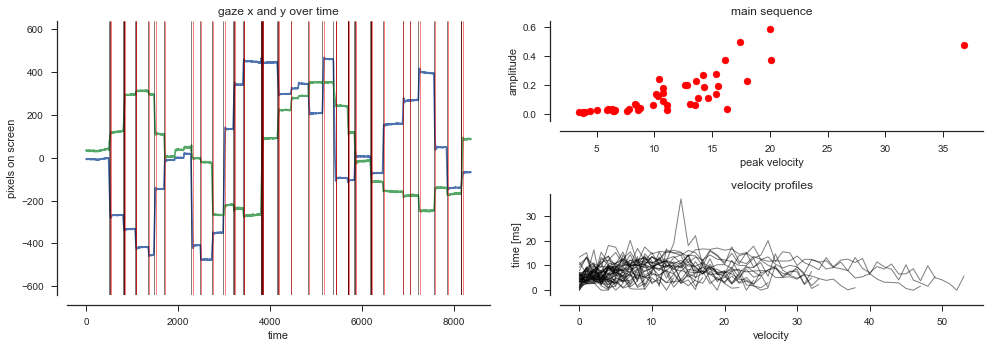

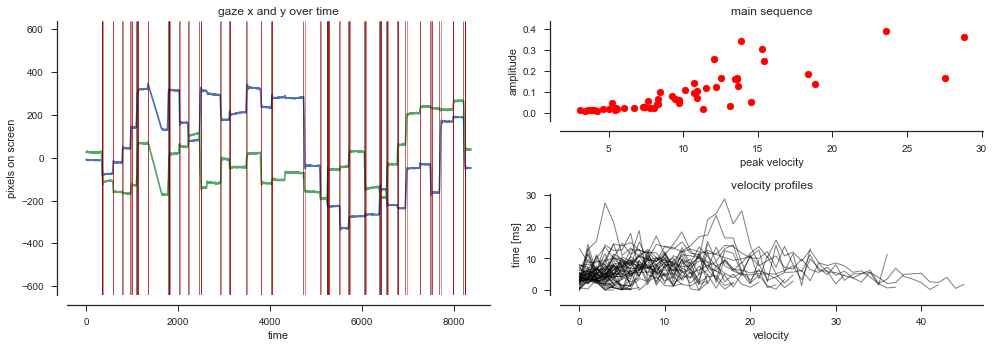

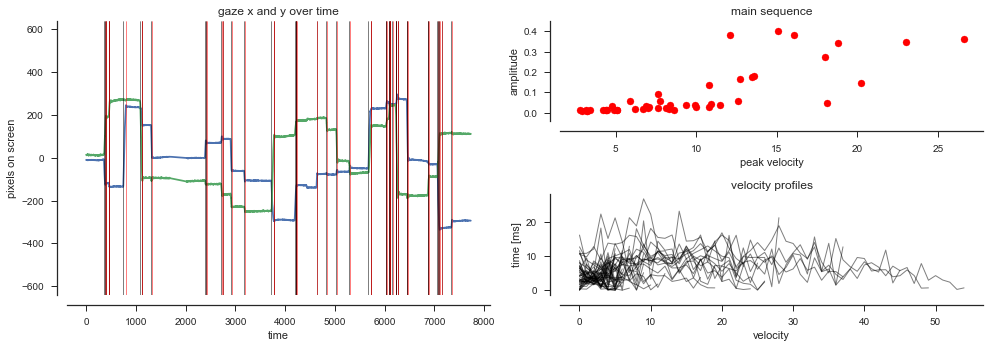

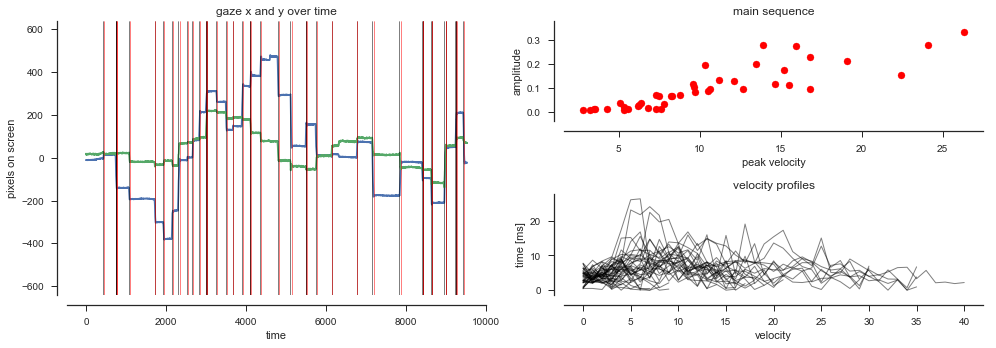

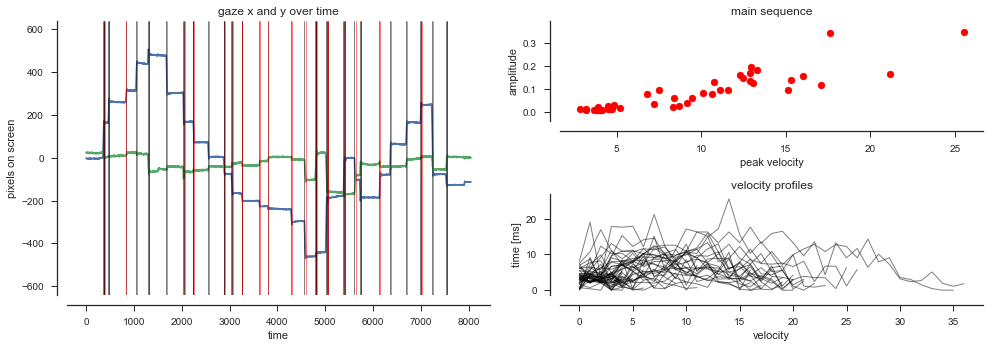

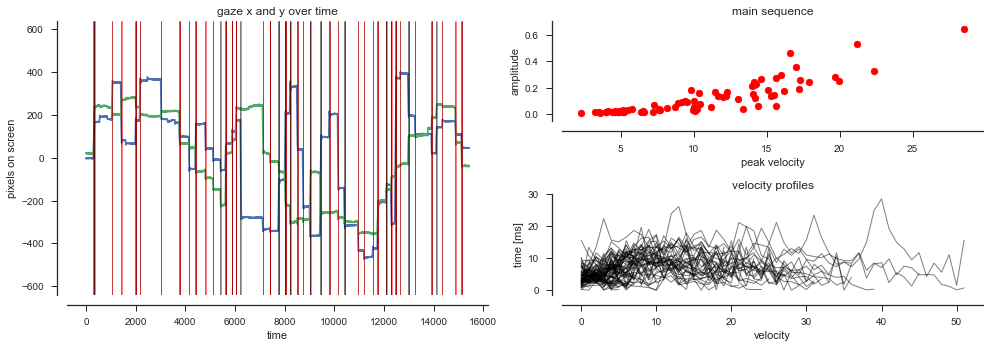

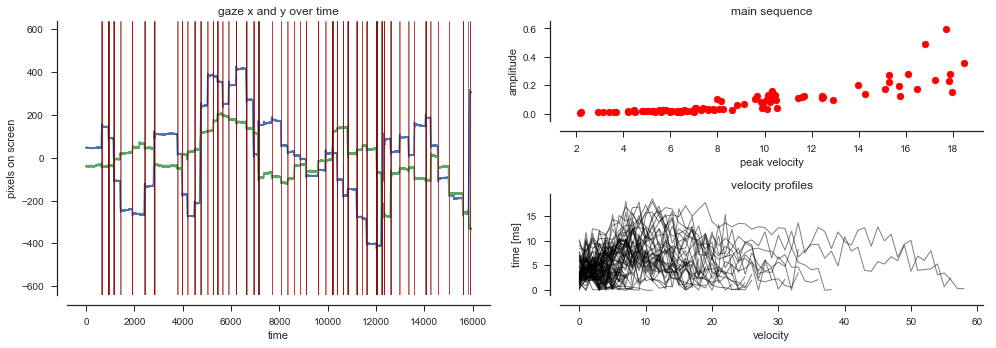

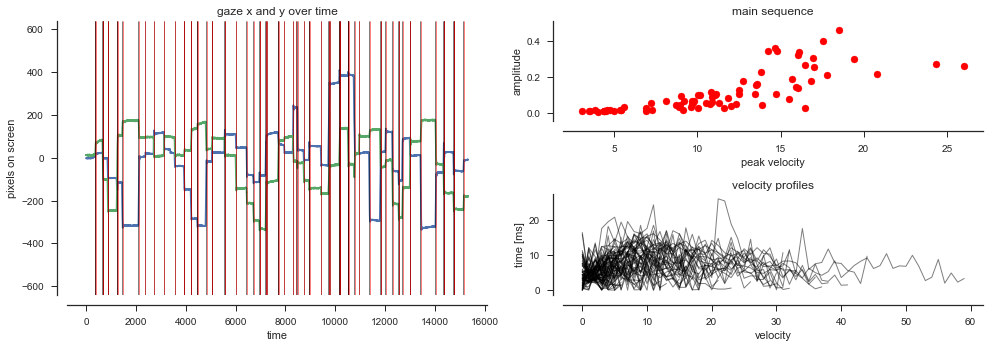

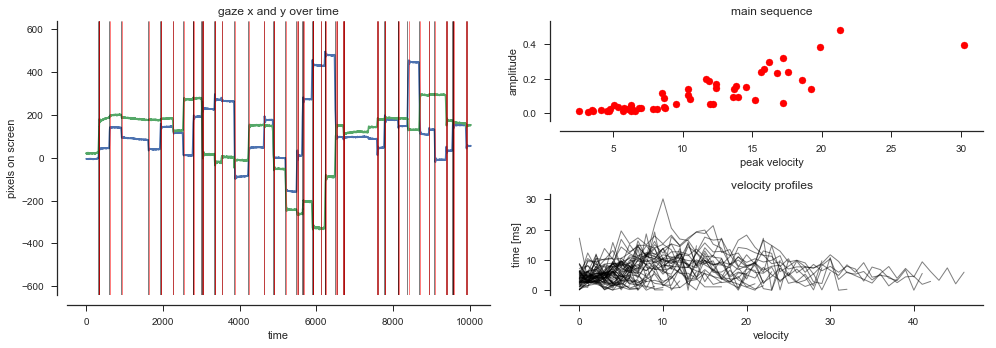

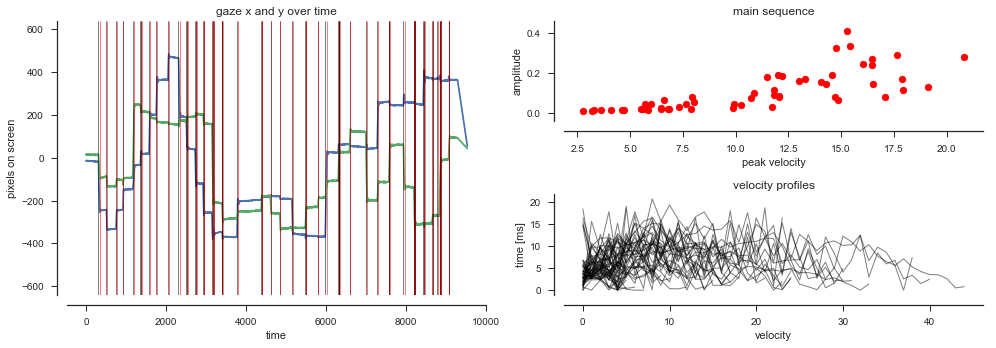

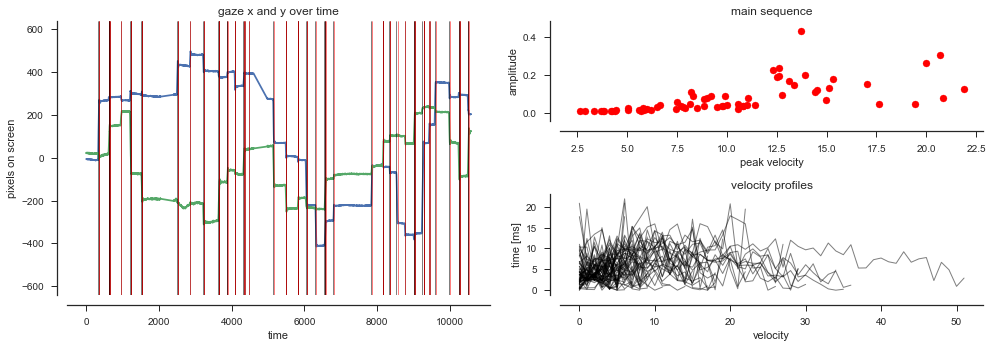

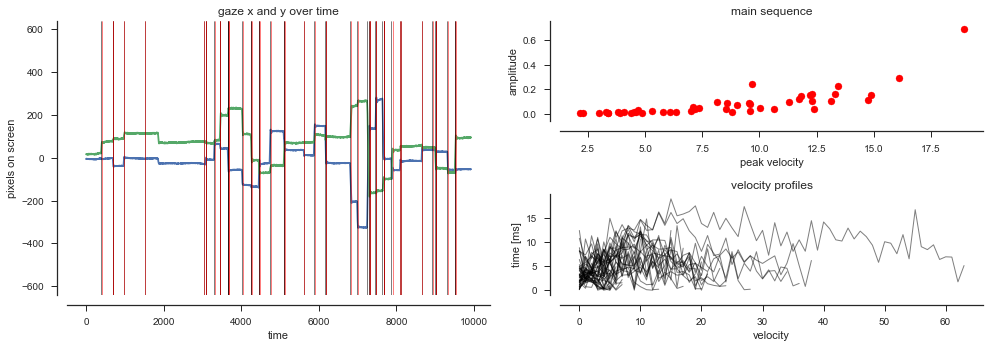

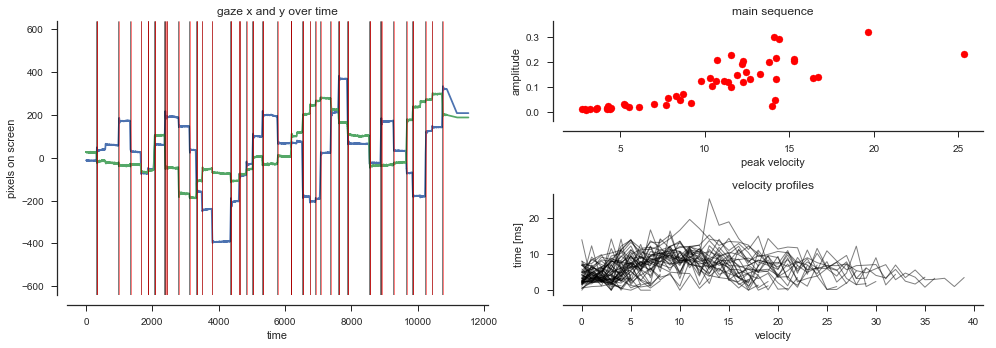

In [34]:
def gaze_over_time(x,y):
    xy_data = np.array([np.array(x).squeeze(),np.array(y).squeeze()]).T
    vel = np.diff(xy_data, axis=0)
    vel_norm = np.linalg.norm(vel, axis=1)

    saccades = detect_saccade_from_data(xy_data=xy_data, 
                                        l=3, 
                                        minimum_saccade_duration=0.0025)
    
    main_sequence = np.array([[sacc['peak_velocity'], sacc['expanded_amplitude'], sacc['expanded_duration']] 
                      for sacc in saccades])

    f = pl.figure(figsize = (14,5))
    s = f.add_subplot(121)
    pl.plot(np.array(x)-640)
    pl.plot(np.array(y)-480)
    s.set_ylim([-640,640])    
    sn.despine(ax=s, offset=10)
    s.set_title('gaze x and y over time')
    for sacc in saccades:
        s.axvline(sacc['expanded_start_time'], lw=0.5, color='k')
        s.axvline(sacc['expanded_end_time'], lw=0.5, color='r')
    s.set_xlabel('time')
    s.set_ylabel('pixels on screen')
    
    s = f.add_subplot(222)
    pl.scatter(main_sequence[:,0], main_sequence[:,1], c='r')
    sn.despine(ax=s, offset=10)
    s.set_title('main sequence')
    s.set_xlabel('peak velocity')
    s.set_ylabel('amplitude')

    s = f.add_subplot(224)
    for sacc in saccades:
        pl.plot(vel_norm[sacc['expanded_start_time']:sacc['expanded_end_time']], 'k', lw=1, alpha=0.5)
    sn.despine(ax=s, offset=10)
    s.set_title('velocity profiles')
    pl.tight_layout()
    s.set_xlabel('velocity')
    s.set_ylabel('time [ms]')

for i in range(13):
    gaze_over_time(gaze_data[i][0], gaze_data[i][1])  

